In [ ]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import scipy.stats as ss

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **Вычисление функции сдвига**

Посчитаем эмпирическую и настоящую функцию сдвига для различных известных распределений.



*   нормальные $N(0,1)$ и $N(0,4)$
*   логнормальные $ln N(0, 1)$ и $ln N(0, 1/4)$
*   бимодальные, состоящие из двух нормальных с соотношением $40/60$
*   бета-распределения $10B(2,8)$ и $5B(2,8) + 3$
*   нормальное и Коши: $N(0,1)$ и $C(0,1.5)$
*   Парето распределения: $pareto(1)$ и $2pareto(3)$

Нас интересует насколько "правильное" значение функции сдвига отличается от эмпирического (т.е. разность выборочных квантилей).


Заметим, что для распределений с непрерывными плотностями $\forall \alpha \in (0,1)$:

$$
\sqrt{n}(X_{\alpha} - x_{\alpha}) ⇒ N(0, \frac{1}{p^2(x_{\alpha})})
$$

где $x_{\alpha}$ - истинный квантиль уровня $\alpha$, а $X_\alpha$ -выборочный.

Тогда можем вместе с функцией сдвига изобразить доверительные интервалы для каждого $\alpha \in (0,1)$.

In [ ]:
draw_confidence_intervals_flag = True   # можно не изображать, тогда поставьте флаг в False

In [ ]:
class Bi_norm(ss.rv_continuous):
    def __init__(self,prop = [1.0, 0.0], loc1 = 0, loc2 = 0):
        ss.rv_continuous.__init__(self)
        self.prop = prop
        self.loc1 = loc1
        self.loc2 = loc2
    
    def _pdf(self, x):
        return self.prop[0] * ss.norm.pdf(x, loc = self.loc1) + self.prop[1] * ss.norm.pdf(x, loc = self.loc2)

    def _cdf(self, x):
        return self.prop[0] * ss.norm.cdf(x, loc = self.loc1) + self.prop[1] * ss.norm.cdf(x, loc = self.loc2)

    def _rvs(self, size, random_state):
        selector = ss.rv_discrete(values=([0, 1], self.prop))
        sel_sample = selector.rvs(size=size, random_state=random_state)
        sample0 = ss.norm(loc = self.loc1).rvs(size=size, random_state=random_state)
        sample1 = ss.norm(loc = self.loc2).rvs(size=size, random_state=random_state)
        return sample0 * (sel_sample == 0) + sample1 * (sel_sample == 1)

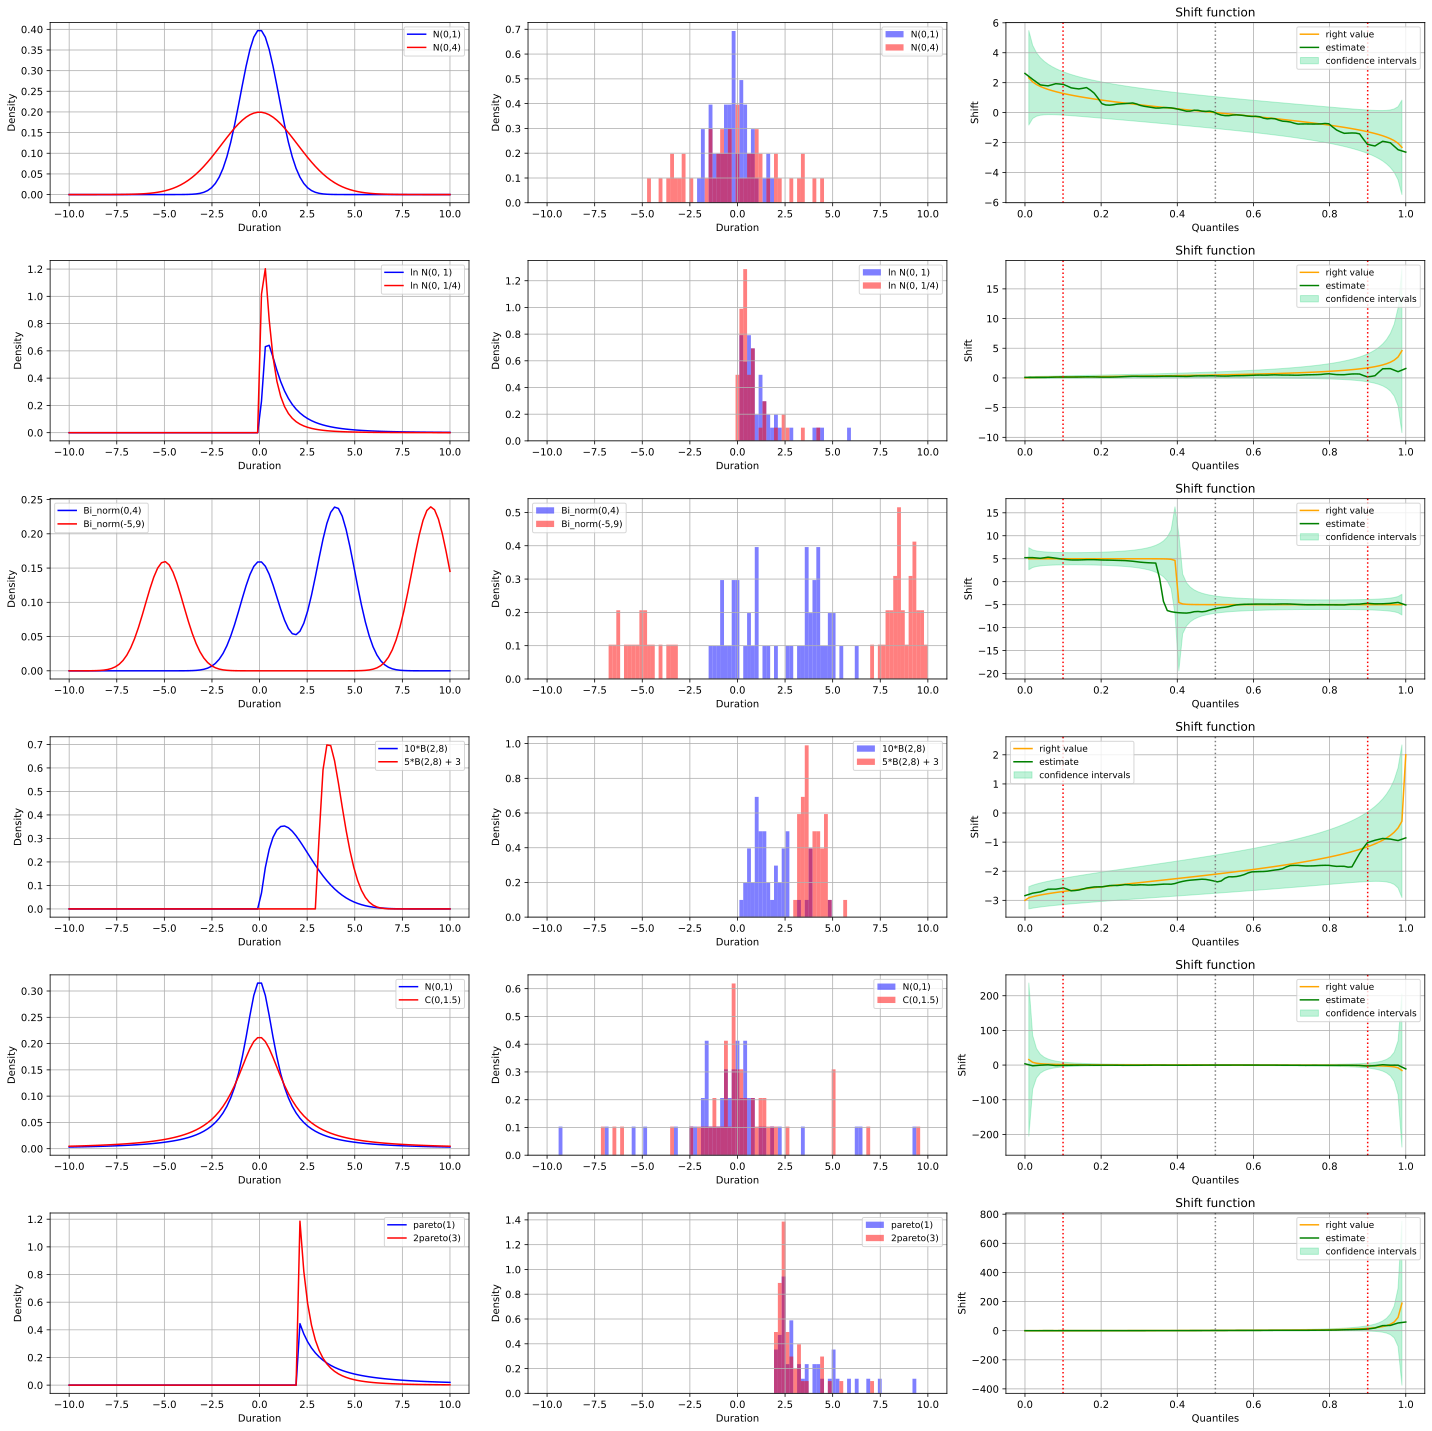

In [ ]:
x = np.linspace(-10,10,100)
quantiles = np.linspace(0,1,100)

s = 0.954
N = 50      #sample size

distributions = [(ss.norm(), ss.norm(scale=2)),
                 (ss.lognorm(s), ss.lognorm(s, scale=1/2)),
                 (Bi_norm(prop=[0.4,0.6], loc1 = 0, loc2 = 4), Bi_norm(prop=[0.4,0.6], loc1 = -5, loc2 = 9)),
                 (ss.beta(a=2,b=8,scale=10), ss.beta(a=2,b=8,scale= 5, loc = 3)),
                 (ss.cauchy(), ss.cauchy(scale=1.5)),
                 (ss.pareto(1, scale = 2), ss.pareto(3, scale = 2))]

labels = [("N(0,1)", "N(0,4)"),
          ("ln N(0, 1)", "ln N(0, 1/4)"),
          ("Bi_norm(0,4)","Bi_norm(-5,9)"),
          ("10*B(2,8)", "5*B(2,8) + 3"),
          ("N(0,1)", "C(0,1.5)"),
          ("pareto(1)", "2pareto(3)")]


fig, axs = plt.subplots(6, 3)
fig.set_figheight(20)
fig.set_figwidth(20)

for (i, (X, Y)), (label_x, label_y) in zip(enumerate(distributions), labels):
  sample_blue = X.rvs(size=N, random_state=42)
  sample_red = Y.rvs(size=N, random_state=7)

  axs[i,0].plot(x, X.pdf(x), color="blue", label=label_x)
  axs[i,0].plot(x, Y.pdf(x), color="red", label=label_y)
  axs[i,0].grid()
  axs[i,0].legend(fontsize=9)
  axs[i,0].set(xlabel='Duration', ylabel='Density')


  axs[i,1].hist(sample_blue, bins=x, density= True, color="blue", label=label_x, alpha = 0.5)
  axs[i,1].hist(sample_red, bins=x, density= True, color="red", label=label_y, alpha = 0.5)
  axs[i,1].grid()
  axs[i,1].legend(fontsize=9)
  axs[i,1].set(xlabel='Duration', ylabel='Density')

  axs[i,2].plot(quantiles, X.ppf(quantiles) - Y.ppf(quantiles), color="orange", label="right value")
  axs[i,2].plot(quantiles, np.quantile(sample_blue, quantiles) - np.quantile(sample_red, quantiles), color="green", label="estimate")
  axs[i,2].set_title("Shift function")
  axs[i,2].grid()
  axs[i,2].set(xlabel='Quantiles', ylabel='Shift')
  axs[i,2].axvline(x=0.5, color = "grey", linestyle=":")
  axs[i,2].axvline(x=0.1, color= "red", linestyle=":")
  axs[i,2].axvline(x=0.9, color= "red", linestyle=":")  
  if draw_confidence_intervals_flag:
    z = 2 # with ~90% probability estimate in confidence interval
    error = (z / np.sqrt(N))* np.sqrt(quantiles * (1 - quantiles)) * (1/(X.pdf(X.ppf(quantiles))) + 1/(Y.pdf(Y.ppf(quantiles))))
    shift_func = X.ppf(quantiles) - Y.ppf(quantiles)
    axs[i,2].fill_between(quantiles, shift_func - error, shift_func + error, alpha=0.25, color='#00CC66', label="confidence intervals")
  axs[i,2].legend(fontsize=9)

fig.tight_layout()
fig.show()


# Анализ результатов

Посмотрим, что получилось:

*   нормальные  - хорошая стабильная оценка
*   логнормальные - шум в правом хвосте (0.9 - 1)
*   бимодальные - взрыв в точке 0.4
*   бета-распределения - шум в правом хвосте (0.8 - 1)
*   нормальное и Коши - шумы в обоих хвостах (0 - 0.1 и 0.9 - 1)
*   Парето распределения - шум в правом хвосте (0.9 - 1)

Нетрудно понять почему мы получаем большое отличие в значениях оценки и истинного значения функции сдвига в крайних значениях (0-0.1 и/или 0.9-1):
всё из-за тяжелых хвостов самих распределений. Длина доверительного интервала, который мы можем построить линейно зависит от $\frac{1}{p(x_{\alpha})}$. При большом $x_{\alpha}$ значения плотности очень мало, но при этом $\alpha$ достаточно маленькое, чтобы мы увидели взрыв и шумы на графике. В случае тяжелых хвостов, при маленькой выборке мы очень неуверены в нашей оценке в значениях 0 - 0.1 и 0.9 - 1.

Таким образом, самый интересный случай - бимодальное распределение. Там в окрестности значения 0.4 мы имеем взрыв и наша оценка очень сильно ошибается.
Происходит это, в общем, по той же причине: в окрестности точки $x_{α}$ обе плотности имеют очень маленькое значение (вообще примерно там локальный минимум плотностей). Поэтому наша оценка очень плохо ведет себя в окрестности 0.4, в ней длина нашего доверительного интервала сильно растёт.

Рассмотрим ещё один пример, демонстрирующий это явление:

# **Более сложный пример**

Расмотрим два бимодальных распределения, состоящих из распределений Коши с соотношением $30/70$, которые имеют пики на разных расстояниях.

В точке 0.3 мы получим увеличение длины доверительного интервала, а значит, мы ожидам, что там наша оценка будет сильно ошибаться.

Давайте убьем эту ошибку добавив между двумя распределениями Коши нормальное, сохранив соотношение между пиками Коши.

In [ ]:
draw_confidence_intervals_flag = True   #draw or not

(имеет смысл после первого запуска изменить флаг на False, чтобы лучше увидеть как мы уменьшили ошибку)

In [ ]:
class Bi_Cauchy(ss.rv_continuous):
    def __init__(self,prop = [1.0, 0.0], loc1 = 0, loc2 = 0):
        ss.rv_continuous.__init__(self)
        self.prop = prop
        self.loc1 = loc1
        self.loc2 = loc2
    
    def _pdf(self, x):
        return self.prop[0] * ss.cauchy.pdf(x, loc = self.loc1) + self.prop[1] * ss.cauchy.pdf(x, loc = self.loc2)

    def _cdf(self, x):
        return self.prop[0] * ss.cauchy.cdf(x, loc = self.loc1) + self.prop[1] * ss.cauchy.cdf(x, loc = self.loc2)

    def _rvs(self, size, random_state):
        selector = ss.rv_discrete(values=([0, 1], self.prop))
        sel_sample = selector.rvs(size=size, random_state=random_state)
        sample0 = ss.cauchy(loc = self.loc1).rvs(size=size, random_state=random_state)
        sample1 = ss.cauchy(loc = self.loc2).rvs(size=size, random_state=random_state)
        return sample0 * (sel_sample == 0) + sample1 * (sel_sample == 1)

In [ ]:
class Multi(ss.rv_continuous):
    def __init__(self,prop = [1.0, 0.0, 0.0], loc1 = 0, loc2 = 0):
        ss.rv_continuous.__init__(self)
        self.prop = prop
        self.loc1 = loc1
        self.loc2 = loc2
    
    def _pdf(self, x):
        return self.prop[0] * ss.cauchy.pdf(x, loc = self.loc1) + self.prop[1] * ss.cauchy.pdf(x, loc = self.loc2) + self.prop[2] * ss.norm.pdf(x)

    def _cdf(self, x):
        return self.prop[0] * ss.cauchy.cdf(x, loc = self.loc1) + self.prop[1] * ss.cauchy.cdf(x, loc = self.loc2) + self.prop[2] * ss.norm.cdf(x)

    def _rvs(self, size, random_state):
        selector = ss.rv_discrete(values=([0, 1, 2], self.prop))
        sel_sample = selector.rvs(size=size, random_state=random_state)
        sample0 = ss.cauchy(loc = self.loc1).rvs(size=size, random_state=random_state)
        sample1 = ss.cauchy(loc = self.loc2).rvs(size=size, random_state=random_state)
        sample2 = ss.norm().rvs(size=size, random_state=random_state)
        return sample0 * (sel_sample == 0) + sample1 * (sel_sample == 1) + sample2 * (sel_sample == 2)

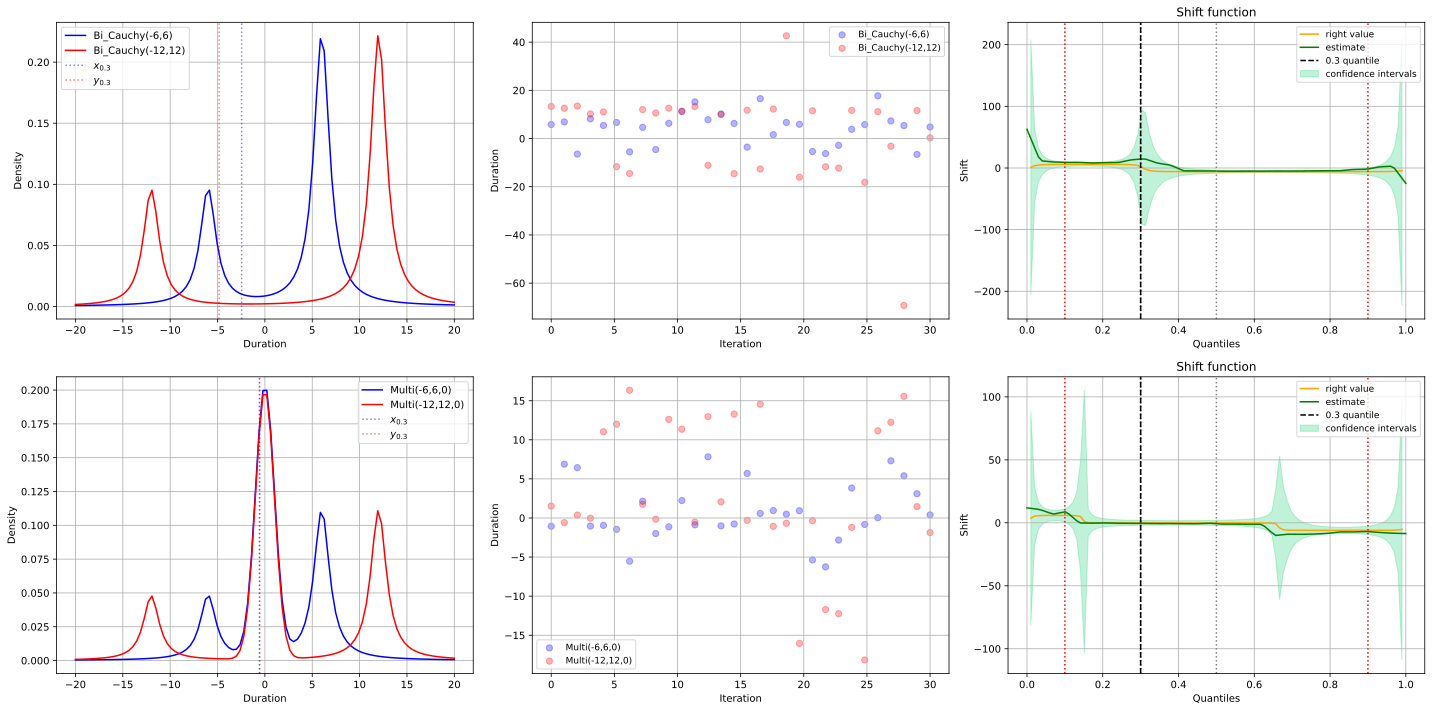

In [ ]:
x = np.linspace(-20,20,100)
quantiles = np.linspace(0,1,100)
bins = np.linspace(0,1,100)

s = 0.954
N = 30                                 #sample size
bins = np.linspace(0,N,N)

p = 1/2


distributions = [ (Bi_Cauchy(prop=[0.3, 0.7], loc1 = -6, loc2 = 6), Bi_Cauchy(prop=[0.3, 0.7], loc1 = -12, loc2 = 12)),
                 (Multi(prop=[3*(1-p)/10, 7*(1-p)/10, p], loc1=-6, loc2=6),Multi(prop=[3*(1-p)/10, 7*(1-p)/10, p], loc1=-12, loc2=12))]

labels = [("Bi_Cauchy(-6,6)", "Bi_Cauchy(-12,12)"),
          ("Multi(-6,6,0)", "Multi(-12,12,0)")]


fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)

for (i, (X, Y)), (label_x, label_y) in zip(enumerate(distributions), labels):
  # print(i, X, Y)
  sample_blue = X.rvs(size=N, random_state=37)
  sample_red = Y.rvs(size=N, random_state=73)

  axs[i,0].plot(x, X.pdf(x), color="blue", label=label_x)
  axs[i,0].plot(x, Y.pdf(x), color="red", label=label_y)
  axs[i,0].axvline(x=X.ppf(0.3), color= "blue", linestyle=":", alpha = 0.5, label=r"$x_{0.3}$")
  axs[i,0].axvline(x=Y.ppf(0.3), color= "red", linestyle=":", alpha=0.5, label=r"$y_{0.3}$")
  axs[i,0].grid()
  axs[i,0].legend(fontsize=10)
  axs[i,0].set(xlabel='Duration', ylabel='Density')

  axs[i,1].scatter(bins, sample_blue, alpha=0.3, color="blue",s=40, label=label_x)
  axs[i,1].scatter(bins, sample_red, alpha=0.3, color="red",s=40, label=label_y)
  axs[i,1].grid()
  axs[i,1].legend(fontsize=9)
  axs[i,1].set(xlabel='Iteration', ylabel='Duration')

  axs[i,2].plot(quantiles, X.ppf(quantiles) - Y.ppf(quantiles), color="orange", label="right value")
  axs[i,2].plot(quantiles, np.quantile(sample_blue, quantiles) - np.quantile(sample_red, quantiles), color="green", label="estimate")
  axs[i,2].set_title("Shift function")
  axs[i,2].grid()
  axs[i,2].axvline(x=0.3, color= "black", linestyle="--", label="0.3 quantile")
  axs[i,2].set(xlabel='Quantiles', ylabel='Shift')
  axs[i,2].axvline(x=0.5, color = "grey", linestyle=":")
  axs[i,2].axvline(x=0.1, color= "red", linestyle=":")
  axs[i,2].axvline(x=0.9, color= "red", linestyle=":")
  axs[i,2].axvline(x=0.3, color= "black", linestyle=":")
  if draw_confidence_intervals_flag:
    z = 2 # with ~90% probability estimate in confidence interval
    error = (z / np.sqrt(N))* np.sqrt(quantiles * (1 - quantiles)) * (1/(X.pdf(X.ppf(quantiles))) + 1/(Y.pdf(Y.ppf(quantiles))))
    shift_func = X.ppf(quantiles) - Y.ppf(quantiles)
    axs[i,2].fill_between(quantiles, shift_func - error, shift_func + error, alpha=0.25, color='#00CC66', label="confidence intervals")
  axs[i,2].legend(fontsize=9)

fig.tight_layout()
fig.show()




# Что произошло? 

Мы изменили распределение так, чтобы в окрестности $x_{0.3}$ была большая плотность и получили, что оценка функции сдвига в окрестности 0.3 слабо отличается от истинной (правда взрывы появились в других местах).

# **Вывод**

Наша ошибка на интервале $I$ (в некотором смысле) пропорциональна $max_{\alpha \in I}\frac{1}{{F'(F^{-1}(\alpha))}} (= (F^{-1}(\alpha))')$, что вообще сразу видно из асимптотической дисперсии выборочного квантиля, но мы это увидели ещё и на картинках.